In [2]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Load CSVs (features x samples format, so we need to transpose)
gene_df = pd.read_csv("../NewDatasets/processed_expression_4O.csv", index_col=0).T
meth_df = pd.read_csv("../NewDatasets/processed_methylation_4O.csv", index_col=0).T
cnv_df  = pd.read_csv("../NewDatasets/processed_cnv_4O.csv", index_col=0).T
protein_df = pd.read_csv("../NewDatasets/processed_protein_4O.csv", index_col=0).T

# apply standard scaling to all data
scaler_meth = StandardScaler()
meth_df = pd.DataFrame(
    scaler_meth.fit_transform(meth_df.T).T,
    index=meth_df.index,
    columns=meth_df.columns
)

scaler_cnv = StandardScaler()
cnv_df = pd.DataFrame(
    scaler_cnv.fit_transform(cnv_df.T).T,
    index=cnv_df.index,
    columns=cnv_df.columns
)
scaler_gene = StandardScaler()
gene_df = pd.DataFrame(
    scaler_gene.fit_transform(gene_df.T).T,
    index=gene_df.index,
    columns=gene_df.columns
)
scaler_protein = StandardScaler()
protein_df = pd.DataFrame(
    scaler_protein.fit_transform(protein_df.T).T,
    index=protein_df.index,
    columns=protein_df.columns
)

print("After transpose - Shapes (samples x features):")
print(f"gene_df: {gene_df.shape}")
print(f"meth_df: {meth_df.shape}")
print(f"cnv_df: {cnv_df.shape}")
print(f"protein_df: {protein_df.shape}")

After transpose - Shapes (samples x features):
gene_df: (265, 44750)
meth_df: (269, 419546)
cnv_df: (248, 56751)
protein_df: (226, 456)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
print("NaN counts:", gene_df.isna().sum().sum(),
      meth_df.isna().sum().sum(),
      cnv_df.isna().sum().sum(),
      protein_df.isna().sum().sum())


NaN counts: 0 0 0 7622


In [ ]:
print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
# Align samples across all three omics
phenotype_df = pd.read_csv("../NewDatasets/phenotype_data_clean_FXS_MOFA_3Omics.csv", index_col=0)
common = gene_df.index.intersection(meth_df.index).intersection(cnv_df.index).intersection(phenotype_df.index)
gene_df = gene_df.loc[common]
meth_df = meth_df.loc[common]
cnv_df  = cnv_df.loc[common]
phenotype_df = phenotype_df.loc[common]
print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
# Convert to float32 tensors
gene = torch.tensor(gene_df.values, dtype=torch.float32).to(device)
meth = torch.tensor(meth_df.values, dtype=torch.float32).to(device)
cnv  = torch.tensor(cnv_df.values, dtype=torch.float32).to(device)
pheno = torch.tensor(phenotype_df.values, dtype=torch.float32).to(device)
print("Tensor shapes:", gene.shape, meth.shape, cnv.shape, pheno.shape)

Shapes: (205, 44663) (205, 419542) (205, 56756)
Shapes: (205, 44663) (205, 419542) (205, 56756)
Shapes: (205, 44663) (205, 419542) (205, 56756)


In [ ]:
def Split(data):
    from sklearn.model_selection import train_test_split
    import numpy as np
    # Load subtype labels
    labels_df = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)

    # Align labels with our data
    common_samples = data.index.intersection(labels_df.index)
    print(f"Samples with labels: {len(common_samples)}")

    # Filter data and labels to common samples
    labels = labels_df.loc[common_samples].values.ravel()
    # Prepare features and labels
    X = data  # Fused latent features
    y = labels  # Cancer subtype labels

    print("="*70)
    print("STRATIFIED DATA SPLITTING BY DISEASE SUBTYPE")
    print("="*70)
    print(f"\n📊 Total samples: {len(X)}")
    print(f"\n🔬 Disease subtype distribution:")

    # Get unique disease subtypes
    unique_subtypes = np.unique(y)
    for subtype_idx in unique_subtypes:
        count = np.sum(y == subtype_idx)
        print(f"   - Subtype {subtype_idx}: {count} samples")

    # ====================================================================
    # Split each disease subtype 80/20, then merge
    # ====================================================================
    print(f"\n{'='*70}")
    print("🔹 Train/Test Split - Stratified by Disease:")
    print(f"{'='*70}")

    X_train_list = []
    X_test_list = []
    y_train_list = []
    y_test_list = []

    for subtype_idx in unique_subtypes:
        # Get samples for this subtype
        subtype_mask = (y == subtype_idx)
        X_subtype = X[subtype_mask]
        y_subtype = y[subtype_mask]
        
        # Split this subtype 80/20
        X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
            X_subtype, y_subtype, test_size=0.2, random_state=42
        )
        
        X_train_list.append(X_train_sub)
        X_test_list.append(X_test_sub)
        y_train_list.append(y_train_sub)
        y_test_list.append(y_test_sub)
        
        print(f"   Subtype {subtype_idx}:")
        print(f"      Train: {len(X_train_sub)} samples ({len(X_train_sub)/len(X_subtype)*100:.1f}%)")
        print(f"      Test:  {len(X_test_sub)} samples ({len(X_test_sub)/len(X_subtype)*100:.1f}%)")

    # Merge all subtypes
    X_train = np.vstack(X_train_list)
    X_test = np.vstack(X_test_list)
    y_train = np.concatenate(y_train_list)
    y_test = np.concatenate(y_test_list)

Training Gene Expression Autoencoder...
Epoch 1/400 | Train Loss: 1.0166 | Val Loss: 0.9880
Epoch 10/400 | Train Loss: 0.7147 | Val Loss: 0.6449
Epoch 20/400 | Train Loss: 0.2784 | Val Loss: 0.1779
Epoch 30/400 | Train Loss: 0.2231 | Val Loss: 0.2466
Epoch 40/400 | Train Loss: 0.1846 | Val Loss: 0.1967
Early stopping triggered!


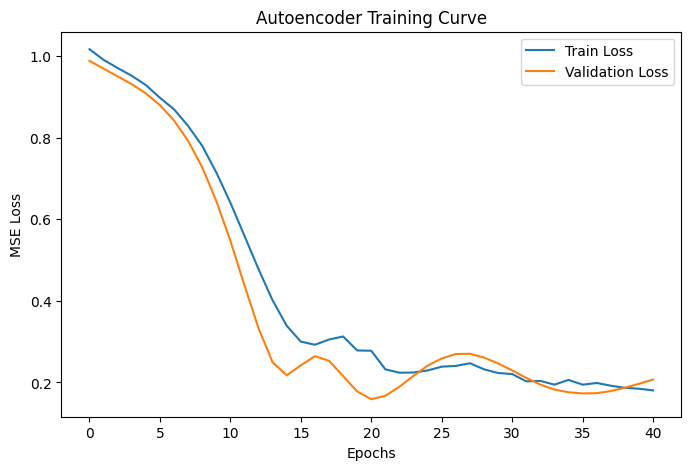


Training Methylation Autoencoder...
Epoch 1/400 | Train Loss: 1.0159 | Val Loss: 1.4559
Epoch 10/400 | Train Loss: 0.9866 | Val Loss: 0.9854
Epoch 20/400 | Train Loss: 0.9637 | Val Loss: 0.9619
Epoch 30/400 | Train Loss: 0.7681 | Val Loss: 0.7667
Epoch 40/400 | Train Loss: 0.2938 | Val Loss: 0.1728
Epoch 50/400 | Train Loss: 0.2428 | Val Loss: 0.3647
Early stopping triggered!


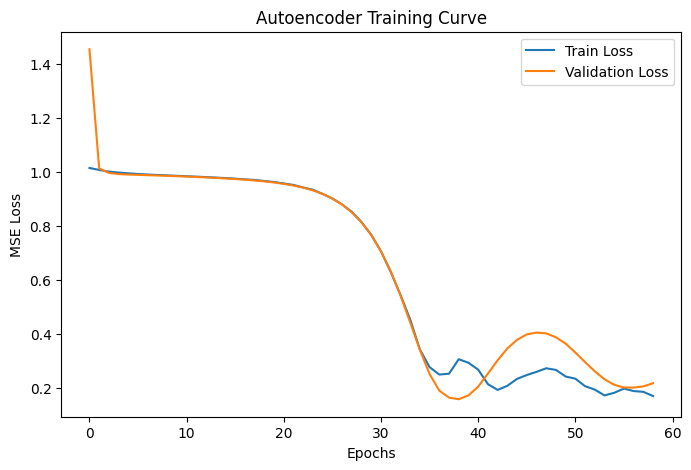


Training CNV Autoencoder...
Epoch 1/400 | Train Loss: 1.0156 | Val Loss: 1.0064
Epoch 10/400 | Train Loss: 0.9939 | Val Loss: 0.9935
Epoch 20/400 | Train Loss: 0.9839 | Val Loss: 0.9830
Epoch 30/400 | Train Loss: 0.9279 | Val Loss: 0.9083
Epoch 40/400 | Train Loss: 0.9044 | Val Loss: 0.9081
Epoch 50/400 | Train Loss: 0.9014 | Val Loss: 0.8836
Epoch 60/400 | Train Loss: 0.8843 | Val Loss: 0.8855
Epoch 70/400 | Train Loss: 0.8550 | Val Loss: 0.8612
Epoch 80/400 | Train Loss: 0.8465 | Val Loss: 0.8473
Epoch 90/400 | Train Loss: 0.8311 | Val Loss: 0.8384
Epoch 100/400 | Train Loss: 0.8148 | Val Loss: 0.8307
Epoch 110/400 | Train Loss: 0.8035 | Val Loss: 0.8250
Epoch 120/400 | Train Loss: 0.7941 | Val Loss: 0.8211
Epoch 130/400 | Train Loss: 0.7935 | Val Loss: 0.8196
Epoch 140/400 | Train Loss: 0.7816 | Val Loss: 0.8147
Epoch 150/400 | Train Loss: 0.7887 | Val Loss: 0.8130
Epoch 160/400 | Train Loss: 0.7761 | Val Loss: 0.8089
Epoch 170/400 | Train Loss: 0.7725 | Val Loss: 0.8123
Epoch 180/

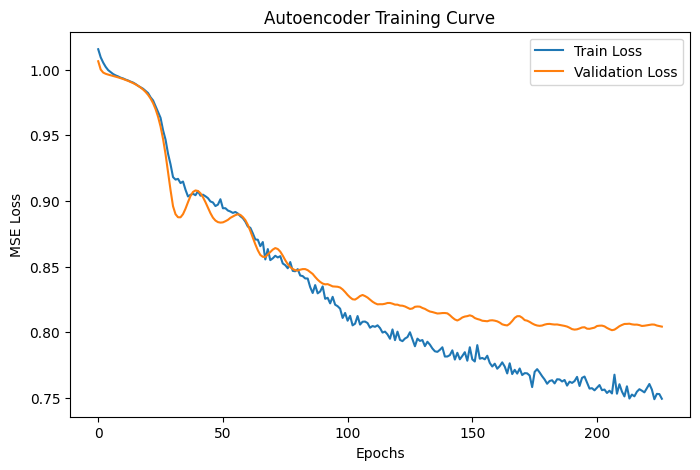


Fused latent shape: torch.Size([205, 96])


In [ ]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32, dropout=0.5):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),      # Smaller first layer
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),            # Gentler compression
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, latent_dim)      # Smaller latent (32 instead of 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon

# ------------------ Training with validation & early stopping ------------------
def train_autoencoder(model, X_train, X_val, epochs=400, patience=20):
    """
    Train autoencoder with validation and early stopping.
    
    Parameters:
    -----------
    model : Autoencoder
        The autoencoder model to train
    X_train : torch.Tensor
        Training data (already on device)
    X_val : torch.Tensor
        Validation data (already on device)
    epochs : int
        Maximum number of training epochs
    patience : int
        Early stopping patience
    
    Returns:
    --------
    model : Autoencoder
        Trained model with best weights restored
    """
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []
    best_val_loss = np.inf
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        z, recon = model(X_train)
        loss = criterion(recon, X_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            _, val_recon = model(X_val)
            val_loss = criterion(val_recon, X_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Plot loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Autoencoder Training Curve")
    plt.legend()
    plt.show()

    return model

# ------------------ Train per omic ------------------
gene_dim, meth_dim, cnv_dim = gene.shape[1], meth.shape[1], cnv.shape[1]

ae_gene = Autoencoder(gene_dim, latent_dim=32).to(device)
ae_meth = Autoencoder(meth_dim, latent_dim=32).to(device)
ae_cnv  = Autoencoder(cnv_dim,  latent_dim=32).to(device)

print("Training Gene Expression Autoencoder...")
# Use 80% of gene data for training, 20% for validation
n_samples = gene.shape[0]
n_train = int(0.8 * n_samples)
gene_train = gene[:n_train]
gene_val = gene[n_train:]
ae_gene = train_autoencoder(ae_gene, gene_train, gene_val)

print("\nTraining Methylation Autoencoder...")
meth_train = meth[:n_train]
meth_val = meth[n_train:]
ae_meth = train_autoencoder(ae_meth, meth_train, meth_val)

print("\nTraining CNV Autoencoder...")
cnv_train = cnv[:n_train]
cnv_val = cnv[n_train:]
ae_cnv = train_autoencoder(ae_cnv, cnv_train, cnv_val)

# ------------------ Extract latents & fuse ------------------
ae_gene.eval(); ae_meth.eval(); ae_cnv.eval()
with torch.no_grad():
    z_gene, _ = ae_gene(gene.to(device))
    z_meth, _ = ae_meth(meth.to(device))
    z_cnv,  _ = ae_cnv(cnv.to(device))

z_fused = torch.cat([z_gene, z_meth, z_cnv], dim=1)
print("\nFused latent shape:", z_fused.shape)


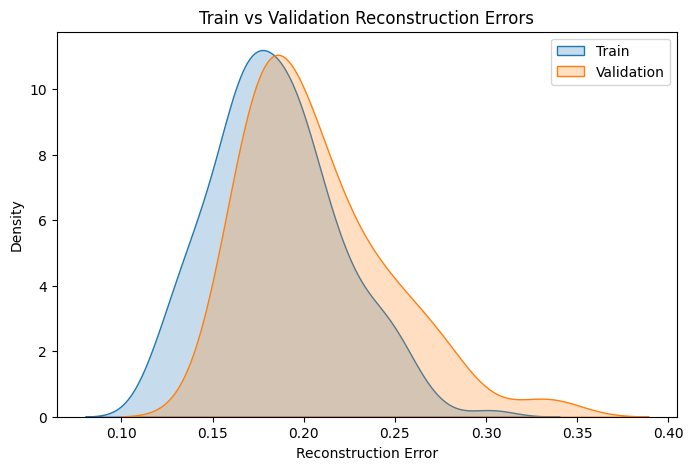

Median Train Err: 0.1807 | Median Val Err: 0.1987
Epoch 1/400 | Train Loss: 1.0149 | Val Loss: 0.9888
Epoch 10/400 | Train Loss: 0.6950 | Val Loss: 0.6029
Epoch 20/400 | Train Loss: 0.2549 | Val Loss: 0.2068
Epoch 30/400 | Train Loss: 0.2231 | Val Loss: 0.2353
Early stopping triggered!


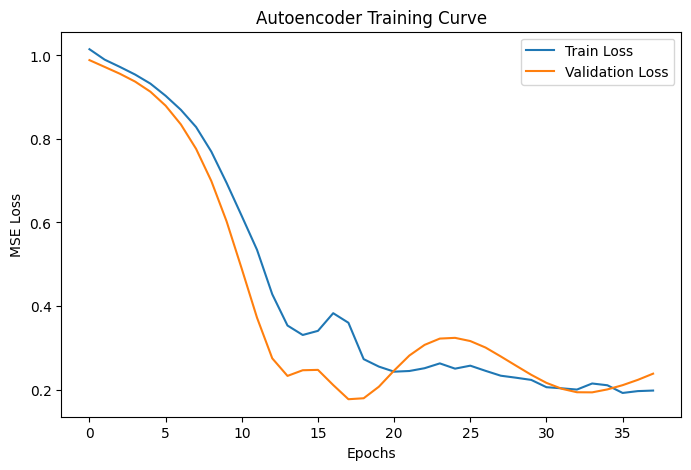

Epoch 1/400 | Train Loss: 1.0164 | Val Loss: 0.9899
Epoch 10/400 | Train Loss: 0.7161 | Val Loss: 0.6467
Epoch 20/400 | Train Loss: 0.2735 | Val Loss: 0.1943
Epoch 30/400 | Train Loss: 0.2213 | Val Loss: 0.2503
Early stopping triggered!


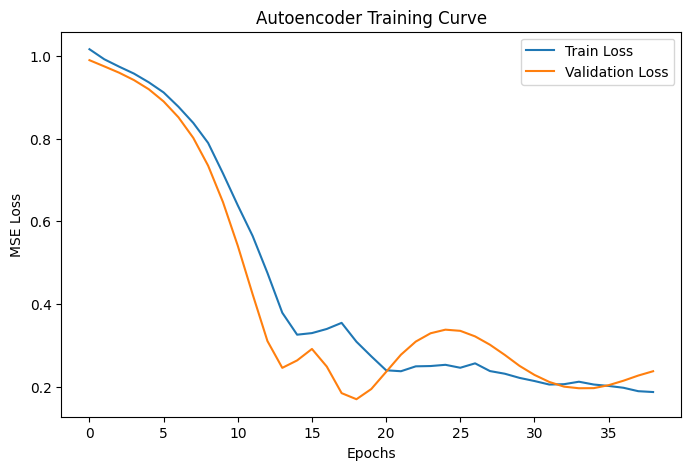

Latent stability (corr between runs): 0.127
Silhouette on fused latents: 0.21240949630737305


In [76]:
from sklearn.metrics import silhouette_score
import seaborn as sns

# ------------------ Diagnostics ------------------
def reconstruction_error_distribution(model, X_train_np, X_val_np, device):
    """Compute and plot per-sample reconstruction errors for train/val."""
    def recon_errors(X_np):
        model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X_np, dtype=torch.float32).to(device)
            _, recon = model(X_t)
        errs = ((recon.cpu().numpy() - X_np)**2).mean(axis=1)
        return errs

    errs_train = recon_errors(X_train_np)
    errs_val   = recon_errors(X_val_np)

    # KDE plots
    plt.figure(figsize=(8,5))
    sns.kdeplot(errs_train, label="Train", shade=True)
    sns.kdeplot(errs_val, label="Validation", shade=True)
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Density")
    plt.title("Train vs Validation Reconstruction Errors")
    plt.legend()
    plt.show()

    print(f"Median Train Err: {np.median(errs_train):.4f} | Median Val Err: {np.median(errs_val):.4f}")

    return errs_train, errs_val

def latent_stability_check(model_class, data, latent_dim, device, n_runs=2):
    """Train AE multiple times and check correlation between latent spaces."""
    latents = []
    for seed in range(n_runs):
        torch.manual_seed(seed)
        np.random.seed(seed)
        model = model_class(data.shape[1], latent_dim=latent_dim).to(device)
        
        # Split data for training
        n_samples = data.shape[0]
        n_train = int(0.8 * n_samples)
        data_train = data[:n_train]
        data_val = data[n_train:]
        
        model = train_autoencoder(model, data_train, data_val)
        with torch.no_grad():
            z, _ = model(data.to(device))
        latents.append(z.cpu().numpy())

    # Compare pairwise correlations
    corr = np.corrcoef(latents[0].ravel(), latents[1].ravel())[0,1]
    print(f"Latent stability (corr between runs): {corr:.3f}")

    return corr

# ------------------ Example usage ------------------
# After training each AE, run diagnostics:

# 1. Check per-sample reconstruction errors
n_samples = gene.shape[0]
n_train = int(0.8 * n_samples)
X_train_np = gene[:n_train].cpu().numpy()
X_val_np = gene[n_train:].cpu().numpy()
errs_train, errs_val = reconstruction_error_distribution(ae_gene, X_train_np, X_val_np, device)

# 2. Latent stability
latent_stability_check(Autoencoder, gene, latent_dim=64, device=device)

# 3. (Optional) Quick clustering sanity check on fused latents
from sklearn.cluster import KMeans
z_np = z_fused.cpu().numpy()
kmeans = KMeans(n_clusters=3, random_state=42).fit(z_np)
score = silhouette_score(z_np, kmeans.labels_)
print("Silhouette on fused latents:", score)


In [77]:
from sklearn.cluster import KMeans

# number of clusters: if unknown, try different values & compare
n_clusters = 3  

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(z_fused.cpu().numpy())


In [78]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

X = z_fused.cpu().numpy()

sil_score = silhouette_score(X, cluster_labels)
ch_score  = calinski_harabasz_score(X, cluster_labels)
db_score  = davies_bouldin_score(X, cluster_labels)

print("Silhouette Score:", sil_score)              # higher is better ([-1, 1])
print("Calinski-Harabasz Score:", ch_score)        # higher is better
print("Davies-Bouldin Score:", db_score)           # lower is better



Silhouette Score: 0.21240949630737305
Calinski-Harabasz Score: 66.83110809326172
Davies-Bouldin Score: 1.673094143798114


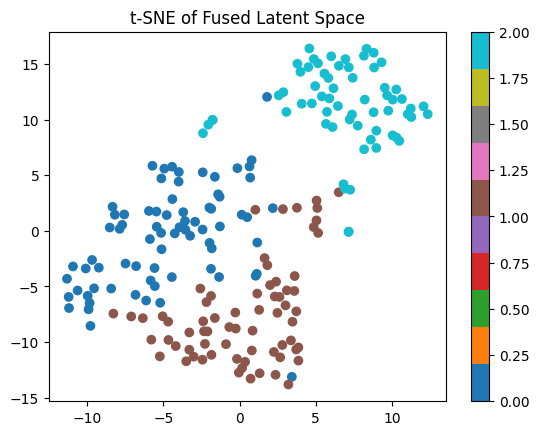

In [79]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z_fused.cpu().numpy())

plt.scatter(z_2d[:,0], z_2d[:,1], c=cluster_labels, cmap="tab10")
plt.colorbar()
plt.title("t-SNE of Fused Latent Space")
plt.show()


In [80]:
# Load subtype labels
labels_df = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)

# Align labels with our data
common_samples = gene_df.index.intersection(labels_df.index)
print(f"Samples with labels: {len(common_samples)}")

# Filter data and labels to common samples
labels = labels_df.loc[common_samples].values.ravel()
z_fused_labeled = z_fused.cpu().numpy()

# If data was already aligned, we might need to reindex
if len(common_samples) < len(gene_df):
    # Refilter if needed
    gene_idx = gene_df.index.get_indexer(common_samples)
    z_fused_labeled = z_fused.cpu().numpy()[gene_idx]

print(f"Final data shape: {z_fused_labeled.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Unique classes: {np.unique(labels)}")
print(f"Class distribution: {np.bincount(labels.astype(int))}")

Samples with labels: 205
Final data shape: (205, 96)
Labels shape: (205,)
Unique classes: [0 1 2 3]
Class distribution: [53 22 96 34]


Embeddings shape: (205, 96)
Labels shape: (205,)
Unique labels: [0 1 2 3]
Computing PCA...
Computing t-SNE...


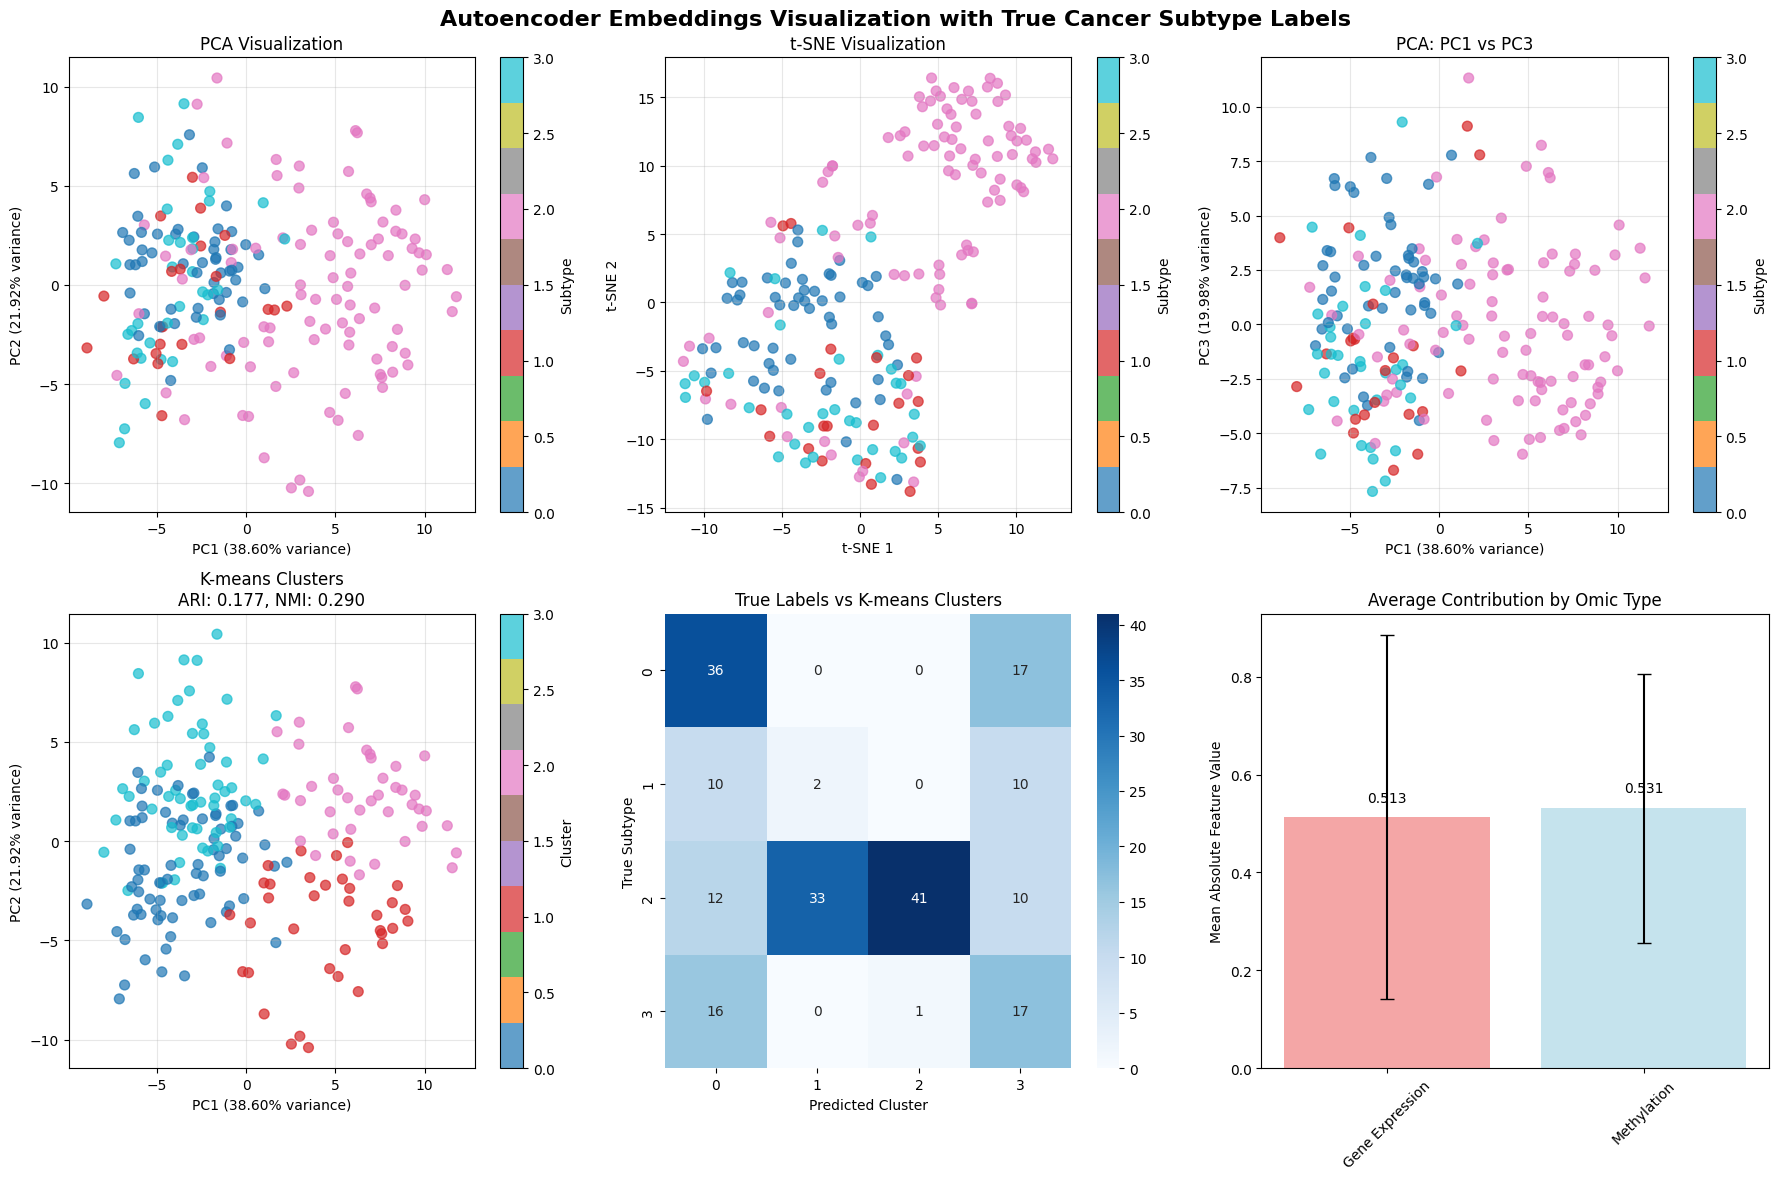

In [81]:
# Visualize embeddings with actual labels
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Get the fused embeddings and labels
embeddings = z_fused_labeled
true_labels = labels

print(f"Embeddings shape: {embeddings.shape}")
print(f"Labels shape: {true_labels.shape}")
print(f"Unique labels: {np.unique(true_labels)}")

# Create label names (assuming 0,1,2,3 are different cancer subtypes)
label_names = {0: 'Subtype 0', 1: 'Subtype 1', 2: 'Subtype 2', 3: 'Subtype 3'}
colored_labels = [label_names.get(int(label), f'Subtype {int(label)}') for label in true_labels]

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Autoencoder Embeddings Visualization with True Cancer Subtype Labels', fontsize=16, fontweight='bold')

# 1. PCA 2D visualization
print("Computing PCA...")
pca_2d = PCA(n_components=2, random_state=42)
embeddings_pca_2d = pca_2d.fit_transform(embeddings)

scatter1 = axes[0, 0].scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], 
                             c=true_labels, cmap='tab10', alpha=0.7, s=50)
axes[0, 0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
axes[0, 0].set_title('PCA Visualization')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Subtype')

# 2. t-SNE 2D visualization
print("Computing t-SNE...")
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne_2d = tsne_2d.fit_transform(embeddings)

scatter2 = axes[0, 1].scatter(embeddings_tsne_2d[:, 0], embeddings_tsne_2d[:, 1], 
                             c=true_labels, cmap='tab10', alpha=0.7, s=50)
axes[0, 1].set_xlabel('t-SNE 1')
axes[0, 1].set_ylabel('t-SNE 2')
axes[0, 1].set_title('t-SNE Visualization')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0, 1], label='Subtype')

# 3. PCA 3D to 2D projections (PC1 vs PC3)
pca_3d = PCA(n_components=3, random_state=42)
embeddings_pca_3d = pca_3d.fit_transform(embeddings)

scatter3 = axes[0, 2].scatter(embeddings_pca_3d[:, 0], embeddings_pca_3d[:, 2], 
                             c=true_labels, cmap='tab10', alpha=0.7, s=50)
axes[0, 2].set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 2].set_ylabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%} variance)')
axes[0, 2].set_title('PCA: PC1 vs PC3')
axes[0, 2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[0, 2], label='Subtype')

# 4. Cluster analysis comparison
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Perform K-means clustering
n_clusters = len(np.unique(true_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
predicted_clusters = kmeans.fit_predict(embeddings)

# Calculate clustering metrics
ari_score = adjusted_rand_score(true_labels, predicted_clusters)
nmi_score = normalized_mutual_info_score(true_labels, predicted_clusters)

scatter4 = axes[1, 0].scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], 
                             c=predicted_clusters, cmap='tab10', alpha=0.7, s=50)
axes[1, 0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
axes[1, 0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
axes[1, 0].set_title(f'K-means Clusters\nARI: {ari_score:.3f}, NMI: {nmi_score:.3f}')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=axes[1, 0], label='Cluster')

# 5. Side-by-side comparison: True vs Predicted
# Create a subplot for confusion-like comparison
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_clusters)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted Cluster')
axes[1, 1].set_ylabel('True Subtype')
axes[1, 1].set_title('True Labels vs K-means Clusters')

# 6. Feature importance heatmap (top features from each omic)
# Show contribution of each omic type to the fused representation
omic_contributions = {
    'Gene Expression': embeddings[:, :64].mean(axis=0),  # First 64 features from gene AE
    'Methylation': embeddings[:, 64:128].mean(axis=0),   # Next 64 features from meth AE  
    'CNV': embeddings[:, 128:192].mean(axis=0)           # Last 64 features from cnv AE
}

omic_means = [np.mean(np.abs(contrib)) for contrib in omic_contributions.values()]
omic_stds = [np.std(np.abs(contrib)) for contrib in omic_contributions.values()]

bars = axes[1, 2].bar(omic_contributions.keys(), omic_means, 
                      yerr=omic_stds, capsize=5, alpha=0.7, 
                      color=['lightcoral', 'lightblue', 'lightgreen'])
axes[1, 2].set_ylabel('Mean Absolute Feature Value')
axes[1, 2].set_title('Average Contribution by Omic Type')
axes[1, 2].set_xticklabels(omic_contributions.keys(), rotation=45)

# Add value labels on bars
for bar, mean_val in zip(bars, omic_means):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*0.05,
                    f'{mean_val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [82]:
# ====================================================================
# CENTRALIZED DATA SPLITTING FOR ALL ML CLASSIFIERS
# ====================================================================
# This cell creates train/test splits used by all models
# Each disease subtype is split 80/20 independently, then merged
# to ensure consistent comparison across different classifiers
# ====================================================================

from sklearn.model_selection import train_test_split
import numpy as np

# Prepare features and labels
X = z_fused_labeled  # Fused latent features
y = labels  # Cancer subtype labels

print("="*70)
print("STRATIFIED DATA SPLITTING BY DISEASE SUBTYPE")
print("="*70)
print(f"\n📊 Total samples: {len(X)}")
print(f"\n🔬 Disease subtype distribution:")

# Get unique disease subtypes
unique_subtypes = np.unique(y)
for subtype_idx in unique_subtypes:
    count = np.sum(y == subtype_idx)
    print(f"   - Subtype {subtype_idx}: {count} samples")

# ====================================================================
# Split each disease subtype 80/20, then merge
# ====================================================================
print(f"\n{'='*70}")
print("🔹 Train/Test Split - Stratified by Disease:")
print(f"{'='*70}")

X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for subtype_idx in unique_subtypes:
    # Get samples for this subtype
    subtype_mask = (y == subtype_idx)
    X_subtype = X[subtype_mask]
    y_subtype = y[subtype_mask]
    
    # Split this subtype 80/20
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
        X_subtype, y_subtype, test_size=0.2, random_state=42
    )
    
    X_train_list.append(X_train_sub)
    X_test_list.append(X_test_sub)
    y_train_list.append(y_train_sub)
    y_test_list.append(y_test_sub)
    
    print(f"   Subtype {subtype_idx}:")
    print(f"      Train: {len(X_train_sub)} samples ({len(X_train_sub)/len(X_subtype)*100:.1f}%)")
    print(f"      Test:  {len(X_test_sub)} samples ({len(X_test_sub)/len(X_subtype)*100:.1f}%)")

# Merge all subtypes
X_train = np.vstack(X_train_list)
X_test = np.vstack(X_test_list)
y_train = np.concatenate(y_train_list)
y_test = np.concatenate(y_test_list)

print(f"\n📦 Merged splits:")
print(f"   - Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   - Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify distribution in train and test
print(f"\n📊 Disease distribution in splits:")
for subtype_idx in unique_subtypes:
    train_count = np.sum(y_train == subtype_idx)
    test_count = np.sum(y_test == subtype_idx)
    print(f"   Subtype {subtype_idx}:")
    print(f"      Train: {train_count} ({train_count/len(y_train)*100:.1f}%)")
    print(f"      Test:  {test_count} ({test_count/len(y_test)*100:.1f}%)")

print(f"\n✅ Data splits created successfully with stratification by disease!")
print(f"   - All ML classifiers will use: X_train, X_test, y_train, y_test")
print("="*70)

STRATIFIED DATA SPLITTING BY DISEASE SUBTYPE

📊 Total samples: 205

🔬 Disease subtype distribution:
   - Subtype 0: 53 samples
   - Subtype 1: 22 samples
   - Subtype 2: 96 samples
   - Subtype 3: 34 samples

🔹 Train/Test Split - Stratified by Disease:
   Subtype 0:
      Train: 42 samples (79.2%)
      Test:  11 samples (20.8%)
   Subtype 1:
      Train: 17 samples (77.3%)
      Test:  5 samples (22.7%)
   Subtype 2:
      Train: 76 samples (79.2%)
      Test:  20 samples (20.8%)
   Subtype 3:
      Train: 27 samples (79.4%)
      Test:  7 samples (20.6%)

📦 Merged splits:
   - Training set: 162 samples (79.0%)
   - Test set: 43 samples (21.0%)

📊 Disease distribution in splits:
   Subtype 0:
      Train: 42 (25.9%)
      Test:  11 (25.6%)
   Subtype 1:
      Train: 17 (10.5%)
      Test:  5 (11.6%)
   Subtype 2:
      Train: 76 (46.9%)
      Test:  20 (46.5%)
   Subtype 3:
      Train: 27 (16.7%)
      Test:  7 (16.3%)

✅ Data splits created successfully with stratification by diseas

In [ ]:
# ====================================================================
# ML CLASSIFICATION USING ml_classifier MODULE
# ====================================================================
from ml_classifier import MLClassifier, train_classifiers

# Train and evaluate all classifiers
ml_clf = train_classifiers(X_train, X_test, y_train, y_test, verbose=True)

# Print results table
ml_clf.print_results()

# Get results as DataFrame
results_df = ml_clf.get_results_dataframe()

# Get best model
best_name, best_model, best_result = ml_clf.get_best_model(metric='Accuracy')
print(f"\n🏆 Best Model: {best_name} with Accuracy: {best_result['Accuracy']:.4f}")

In [ ]:
# ====================================================================
# VISUALIZATION OF ML RESULTS
# ====================================================================

# Plot comprehensive results
ml_clf.plot_results()

# Plot ROC curves
ml_clf.plot_roc_curves()

# Plot confusion matrices
ml_clf.plot_confusion_matrices()

# Survival Analysis Visualization

Now let's perform survival analysis to understand the relationship between cancer subtypes (predicted by our model) and patient outcomes.

In [92]:
# Load and prepare survival data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines.plotting import plot_lifetimes
import warnings
warnings.filterwarnings('ignore')

# Load survival data
survival_df = pd.read_csv("../TCGA-SARC.survival.tsv", sep='\t')
print(f"Survival data shape: {survival_df.shape}")
print(f"Survival data columns: {survival_df.columns.tolist()}")
print(f"Sample survival data:")
print(survival_df.head())

# Check for missing values
print(f"\nMissing values:")
print(survival_df.isnull().sum())

# Basic statistics
print(f"\nSurvival statistics:")
print(f"OS.time range: {survival_df['OS.time'].min():.1f} - {survival_df['OS.time'].max():.1f} months")
print(f"Event rate (deaths): {survival_df['OS'].mean():.3f} ({survival_df['OS'].sum()} out of {len(survival_df)})")
print(f"Median follow-up time: {survival_df['OS.time'].median():.1f} months")

Survival data shape: (269, 4)
Survival data columns: ['sample', 'OS.time', 'OS', '_PATIENT']
Sample survival data:
             sample  OS.time  OS      _PATIENT
0  TCGA-MB-A5YA-01A     15.0   0  TCGA-MB-A5YA
1  TCGA-3R-A8YX-01A     17.0   1  TCGA-3R-A8YX
2  TCGA-HS-A5N8-01A     22.0   1  TCGA-HS-A5N8
3  TCGA-RN-A68Q-01A     22.0   0  TCGA-RN-A68Q
4  TCGA-X6-A7W8-01A     24.0   1  TCGA-X6-A7W8

Missing values:
sample      0
OS.time     0
OS          0
_PATIENT    0
dtype: int64

Survival statistics:
OS.time range: 15.0 - 5723.0 months
Event rate (deaths): 0.379 (102 out of 269)
Median follow-up time: 959.0 months


In [93]:
# Get predictions from the best model for survival analysis
best_model_name = results_df.iloc[0]['Model']
best_clf = classifiers[best_model_name]

# Get predictions for all samples (not just test set)
all_predictions = best_clf.predict(z_fused_labeled)
all_prediction_probs = best_clf.predict_proba(z_fused_labeled)

# Create a mapping of sample indices to predictions
# Assuming gene_df.index contains the sample IDs that match survival data
sample_ids = gene_df.index.tolist()
predictions_df = pd.DataFrame({
    'sample': sample_ids,
    'predicted_subtype': all_predictions,
    'subtype_0_prob': all_prediction_probs[:, 0],
    'subtype_1_prob': all_prediction_probs[:, 1] if all_prediction_probs.shape[1] > 1 else 0,
    'subtype_2_prob': all_prediction_probs[:, 2] if all_prediction_probs.shape[1] > 2 else 0,
    'subtype_3_prob': all_prediction_probs[:, 3] if all_prediction_probs.shape[1] > 3 else 0,
    'max_prob': np.max(all_prediction_probs, axis=1)  # Confidence score
})

print(f"Predictions shape: {predictions_df.shape}")
print(f"Predicted subtypes distribution:")
print(predictions_df['predicted_subtype'].value_counts().sort_index())
print(f"\nSample predictions:")
print(predictions_df.head())

Predictions shape: (205, 7)
Predicted subtypes distribution:
predicted_subtype
0    57
1    24
2    81
3    43
Name: count, dtype: int64

Sample predictions:
             sample  predicted_subtype  subtype_0_prob  subtype_1_prob  \
0  TCGA-3B-A9HV-01A                  2    2.392242e-53    5.752473e-72   
1  TCGA-HS-A5N7-01A                  2   3.224391e-140   1.409582e-143   
2  TCGA-HB-A2OT-01A                  3    3.761904e-35    3.059305e-08   
3  TCGA-QQ-A5VD-01A                  2    4.472629e-51    5.372587e-67   
4  TCGA-DX-A2IZ-01A                  2    1.592539e-23    1.785601e-62   

   subtype_2_prob  subtype_3_prob  max_prob  
0    1.000000e+00    3.624530e-87       1.0  
1    1.000000e+00   5.271546e-141       1.0  
2    7.427185e-49    1.000000e+00       1.0  
3    1.000000e+00    1.008634e-70       1.0  
4    1.000000e+00    1.927928e-70       1.0  


In [94]:
# Merge survival data with predictions
# First, let's align the sample names properly
survival_df['sample_clean'] = survival_df['sample'].str.replace('-01A', '', regex=False)
predictions_df['sample_clean'] = predictions_df['sample'].str.replace('-01A', '', regex=False)

# Merge on cleaned sample names
survival_analysis_df = pd.merge(
    survival_df, 
    predictions_df, 
    left_on='sample_clean', 
    right_on='sample_clean', 
    how='inner'
)

print(f"Merged data shape: {survival_analysis_df.shape}")
print(f"Successfully matched {len(survival_analysis_df)} samples")

if len(survival_analysis_df) == 0:
    print("No matching samples found. Trying direct merge...")
    # Try direct merge without cleaning
    survival_analysis_df = pd.merge(
        survival_df, 
        predictions_df, 
        left_on='sample', 
        right_on='sample', 
        how='inner'
    )
    print(f"Direct merge result: {survival_analysis_df.shape}")

if len(survival_analysis_df) > 0:
    # Clean up column names - pandas creates sample_x and sample_y during merge
    if 'sample_x' in survival_analysis_df.columns:
        survival_analysis_df = survival_analysis_df.rename(columns={'sample_x': 'sample'})
        if 'sample_y' in survival_analysis_df.columns:
            survival_analysis_df = survival_analysis_df.drop(columns=['sample_y'])
    
    print(f"\nSubtype distribution in survival cohort:")
    print(survival_analysis_df['predicted_subtype'].value_counts().sort_index())
    print(f"\nSample of merged data:")
    print(survival_analysis_df[['sample', 'OS.time', 'OS', 'predicted_subtype', 'max_prob']].head())
else:
    print("Warning: No samples could be matched between survival and prediction data")
    print("Sample names in survival data:", survival_df['sample'].head().tolist())
    print("Sample names in prediction data:", predictions_df['sample'].head().tolist())

Merged data shape: (203, 12)
Successfully matched 203 samples

Subtype distribution in survival cohort:
predicted_subtype
0    57
1    24
2    80
3    42
Name: count, dtype: int64

Sample of merged data:
             sample  OS.time  OS  predicted_subtype  max_prob
0  TCGA-MB-A5YA-01A     15.0   0                  2  1.000000
1  TCGA-3R-A8YX-01A     17.0   1                  3  0.999999
2  TCGA-HS-A5N8-01A     22.0   1                  2  0.973058
3  TCGA-X6-A7W8-01A     24.0   1                  1  0.996937
4  TCGA-JV-A5VF-01A     32.0   1                  1  0.995855


In [95]:
# Debug: Check the columns in survival_analysis_df
print("Columns in survival_analysis_df:")
print(survival_analysis_df.columns.tolist())
print("\nDataFrame info:")
print(survival_analysis_df.info())
print("\nFirst few rows:")
print(survival_analysis_df.head())

Columns in survival_analysis_df:
['sample', 'OS.time', 'OS', '_PATIENT', 'sample_clean', 'predicted_subtype', 'subtype_0_prob', 'subtype_1_prob', 'subtype_2_prob', 'subtype_3_prob', 'max_prob']

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sample             203 non-null    object 
 1   OS.time            203 non-null    float64
 2   OS                 203 non-null    int64  
 3   _PATIENT           203 non-null    object 
 4   sample_clean       203 non-null    object 
 5   predicted_subtype  203 non-null    int64  
 6   subtype_0_prob     203 non-null    float64
 7   subtype_1_prob     203 non-null    float64
 8   subtype_2_prob     203 non-null    float64
 9   subtype_3_prob     203 non-null    float64
 10  max_prob           203 non-null    float64
dtypes: float64(6), int64(2), object(3)
memory usage: 17.6+ 

In [96]:
# Clean up column names for clarity
if 'sample_x' in survival_analysis_df.columns:
    survival_analysis_df = survival_analysis_df.rename(columns={'sample_x': 'sample'})
elif 'sample_y' in survival_analysis_df.columns:
    survival_analysis_df = survival_analysis_df.rename(columns={'sample_y': 'sample'})

# Also remove duplicate sample columns if they exist
columns_to_drop = []
if 'sample_y' in survival_analysis_df.columns and 'sample' in survival_analysis_df.columns:
    columns_to_drop.append('sample_y')
if 'sample_x' in survival_analysis_df.columns and 'sample' in survival_analysis_df.columns:
    columns_to_drop.append('sample_x')

if columns_to_drop:
    survival_analysis_df = survival_analysis_df.drop(columns=columns_to_drop)

print("Cleaned columns:", survival_analysis_df.columns.tolist())

Cleaned columns: ['sample', 'OS.time', 'OS', '_PATIENT', 'sample_clean', 'predicted_subtype', 'subtype_0_prob', 'subtype_1_prob', 'subtype_2_prob', 'subtype_3_prob', 'max_prob']


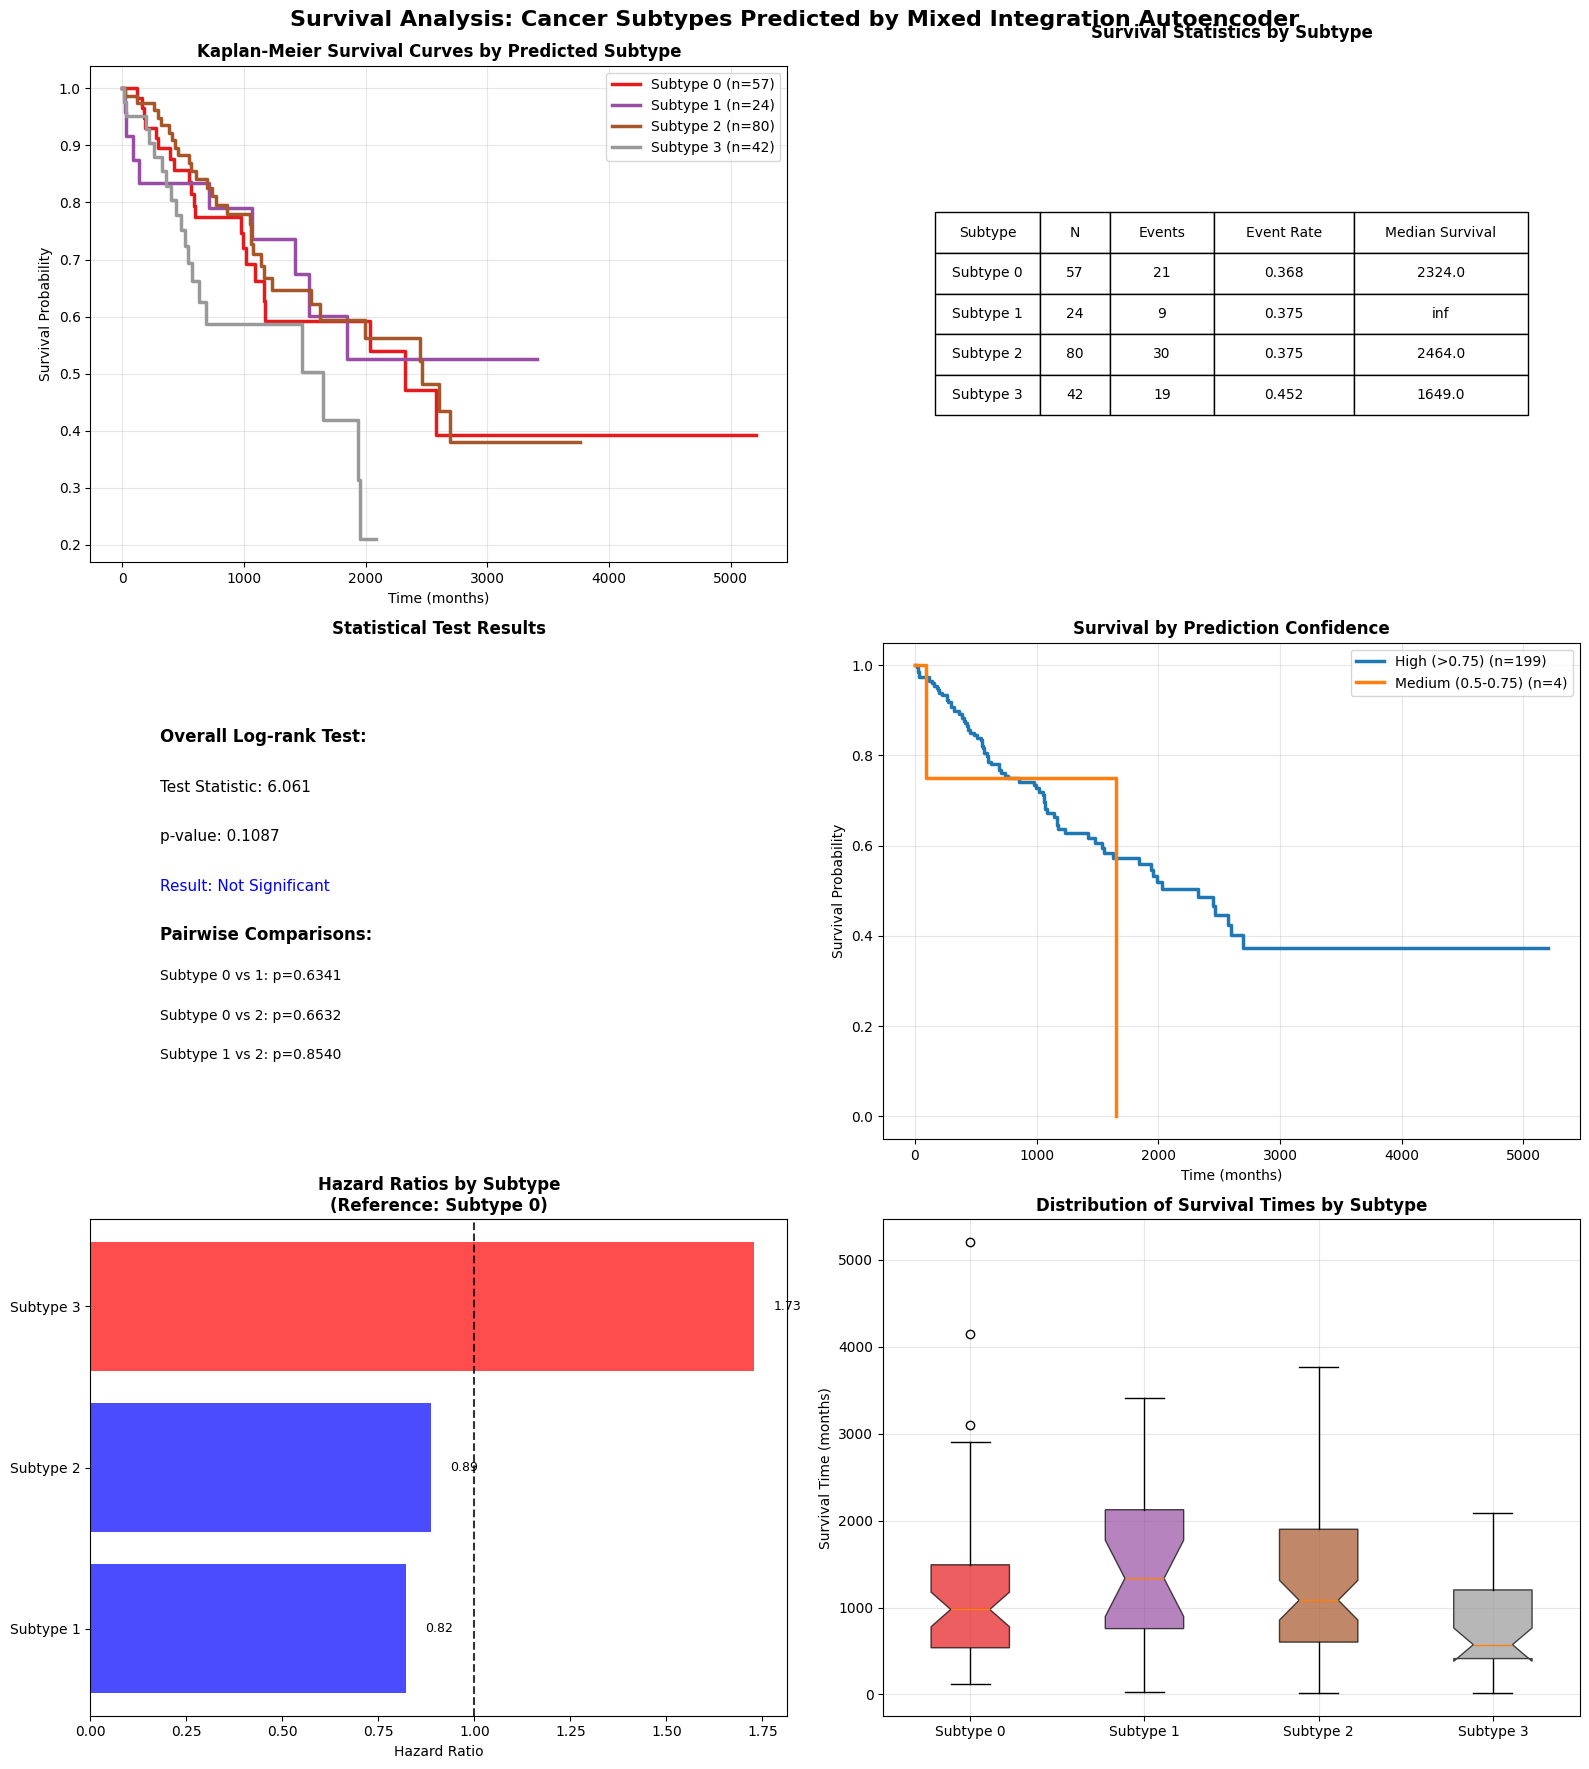


SURVIVAL ANALYSIS SUMMARY
Total patients with survival data: 203
Number of predicted subtypes: 4
Overall event rate (deaths): 0.389
Median follow-up time: 995.0 months


In [97]:
# Comprehensive Survival Analysis Visualization
if len(survival_analysis_df) > 0:
    # Create a comprehensive survival analysis visualization
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('Survival Analysis: Cancer Subtypes Predicted by Mixed Integration Autoencoder', 
                 fontsize=16, fontweight='bold')
    
    # Color palette for subtypes
    n_subtypes = len(survival_analysis_df['predicted_subtype'].unique())
    colors = plt.cm.Set1(np.linspace(0, 1, n_subtypes))
    subtype_colors = {subtype: colors[i] for i, subtype in enumerate(sorted(survival_analysis_df['predicted_subtype'].unique()))}
    
    # 1. Kaplan-Meier Survival Curves by Predicted Subtype
    kmf = KaplanMeierFitter()
    
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        kmf.fit(subtype_data['OS.time'], subtype_data['OS'], 
                label=f'Subtype {subtype} (n={len(subtype_data)})')
        kmf.plot_survival_function(ax=axes[0, 0], color=subtype_colors[subtype], 
                                 linewidth=2.5, ci_show=False)
    
    axes[0, 0].set_title('Kaplan-Meier Survival Curves by Predicted Subtype', fontweight='bold')
    axes[0, 0].set_xlabel('Time (months)')
    axes[0, 0].set_ylabel('Survival Probability')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend(loc='best')
    
    # 2. Survival Statistics Summary
    axes[0, 1].axis('off')
    survival_stats = []
    
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        kmf.fit(subtype_data['OS.time'], subtype_data['OS'])
        
        median_survival = kmf.median_survival_time_
        event_rate = subtype_data['OS'].mean()
        n_patients = len(subtype_data)
        
        survival_stats.append({
            'Subtype': f'Subtype {subtype}',
            'N': n_patients,
            'Events': int(subtype_data['OS'].sum()),
            'Event Rate': f'{event_rate:.3f}',
            'Median Survival': f'{median_survival:.1f}' if not np.isnan(median_survival) else 'Not reached'
        })
    
    stats_df = pd.DataFrame(survival_stats)
    table = axes[0, 1].table(cellText=stats_df.values,
                            colLabels=stats_df.columns,
                            cellLoc='center',
                            loc='center',
                            colWidths=[0.15, 0.1, 0.15, 0.2, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    axes[0, 1].set_title('Survival Statistics by Subtype', fontweight='bold', pad=20)
    
    # 3. Log-rank Test Results
    try:
        # Perform pairwise log-rank tests
        subtypes = sorted(survival_analysis_df['predicted_subtype'].unique())
        if len(subtypes) > 1:
            # Overall log-rank test
            results = multivariate_logrank_test(
                survival_analysis_df['OS.time'],
                survival_analysis_df['predicted_subtype'],
                survival_analysis_df['OS']
            )
            
            axes[1, 0].axis('off')
            axes[1, 0].text(0.1, 0.8, f'Overall Log-rank Test:', fontweight='bold', fontsize=12)
            axes[1, 0].text(0.1, 0.7, f'Test Statistic: {results.test_statistic:.3f}', fontsize=11)
            axes[1, 0].text(0.1, 0.6, f'p-value: {results.p_value:.4f}', fontsize=11)
            significance = "Significant" if results.p_value < 0.05 else "Not Significant"
            axes[1, 0].text(0.1, 0.5, f'Result: {significance}', fontsize=11, 
                           color='red' if results.p_value < 0.05 else 'blue')
            axes[1, 0].set_title('Statistical Test Results', fontweight='bold')
            
            # Pairwise comparisons for first few subtypes
            pairwise_results = []
            for i in range(min(3, len(subtypes))):
                for j in range(i+1, min(3, len(subtypes))):
                    subtype_i_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtypes[i]]
                    subtype_j_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtypes[j]]
                    
                    if len(subtype_i_data) > 5 and len(subtype_j_data) > 5:  # Minimum sample size
                        lr_result = logrank_test(
                            subtype_i_data['OS.time'], subtype_j_data['OS.time'],
                            subtype_i_data['OS'], subtype_j_data['OS']
                        )
                        pairwise_results.append({
                            'Comparison': f'Subtype {subtypes[i]} vs {subtypes[j]}',
                            'Test Statistic': f'{lr_result.test_statistic:.3f}',
                            'p-value': f'{lr_result.p_value:.4f}',
                            'Significant': 'Yes' if lr_result.p_value < 0.05 else 'No'
                        })
            
            if pairwise_results:
                y_pos = 0.4
                axes[1, 0].text(0.1, y_pos, 'Pairwise Comparisons:', fontweight='bold', fontsize=12)
                for idx, result in enumerate(pairwise_results):
                    y_pos -= 0.08
                    axes[1, 0].text(0.1, y_pos, f"{result['Comparison']}: p={result['p-value']}", fontsize=10)
    
    except Exception as e:
        axes[1, 0].text(0.1, 0.5, f'Statistical test error: {str(e)}', fontsize=10)
        axes[1, 0].set_title('Statistical Test Results', fontweight='bold')
    
    # 4. Survival by Prediction Confidence
    # Create confidence groups based on max probability
    survival_analysis_df['confidence_group'] = pd.cut(
        survival_analysis_df['max_prob'], 
        bins=[0, 0.5, 0.75, 1.0], 
        labels=['Low (≤0.5)', 'Medium (0.5-0.75)', 'High (>0.75)']
    )
    
    for conf_group in survival_analysis_df['confidence_group'].dropna().unique():
        group_data = survival_analysis_df[survival_analysis_df['confidence_group'] == conf_group]
        if len(group_data) > 2:
            kmf.fit(group_data['OS.time'], group_data['OS'], label=f'{conf_group} (n={len(group_data)})')
            kmf.plot_survival_function(ax=axes[1, 1], linewidth=2.5, ci_show=False)
    
    axes[1, 1].set_title('Survival by Prediction Confidence', fontweight='bold')
    axes[1, 1].set_xlabel('Time (months)')
    axes[1, 1].set_ylabel('Survival Probability')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend(loc='best')
    
    # 5. Hazard Ratios (Cox Proportional Hazards Model)
    try:
        # Prepare data for Cox regression
        cox_data = survival_analysis_df[['OS.time', 'OS', 'predicted_subtype']].copy()
        
        # Create dummy variables for subtypes (reference: subtype 0)
        subtype_dummies = pd.get_dummies(cox_data['predicted_subtype'], prefix='subtype')
        cox_data = pd.concat([cox_data, subtype_dummies], axis=1)
        
        # Remove reference category and original subtype column
        reference_col = f'subtype_{sorted(survival_analysis_df["predicted_subtype"].unique())[0]}'
        if reference_col in cox_data.columns:
            cox_data = cox_data.drop([reference_col, 'predicted_subtype'], axis=1)
        
        # Fit Cox model
        cph = CoxPHFitter()
        cph.fit(cox_data, duration_col='OS.time', event_col='OS')
        
        # Plot hazard ratios
        hazard_ratios = cph.summary[['coef', 'exp(coef)', 'p']]
        hazard_ratios.columns = ['Log HR', 'Hazard Ratio', 'p-value']
        
        # Create hazard ratio plot
        hr_values = hazard_ratios['Hazard Ratio'].values
        hr_labels = [col.replace('subtype_', 'Subtype ') for col in hazard_ratios.index]
        
        bars = axes[2, 0].barh(range(len(hr_values)), hr_values, 
                              color=['red' if hr > 1 else 'blue' for hr in hr_values],
                              alpha=0.7)
        axes[2, 0].axvline(x=1, color='black', linestyle='--', alpha=0.8)
        axes[2, 0].set_yticks(range(len(hr_labels)))
        axes[2, 0].set_yticklabels(hr_labels)
        axes[2, 0].set_xlabel('Hazard Ratio')
        axes[2, 0].set_title('Hazard Ratios by Subtype\n(Reference: Subtype 0)', fontweight='bold')
        
        # Add HR values on bars
        for i, (bar, hr, p_val) in enumerate(zip(bars, hr_values, hazard_ratios['p-value'])):
            significance = '*' if p_val < 0.05 else ''
            axes[2, 0].text(hr + 0.05, bar.get_y() + bar.get_height()/2, 
                           f'{hr:.2f}{significance}', va='center', fontsize=9)
        
    except Exception as e:
        axes[2, 0].text(0.5, 0.5, f'Cox regression error: {str(e)}', 
                       ha='center', va='center', transform=axes[2, 0].transAxes)
        axes[2, 0].set_title('Hazard Ratios by Subtype', fontweight='bold')
    
    # 6. Survival Distribution by Subtype (Box Plot)
    survival_times_by_subtype = []
    subtype_labels = []
    
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        survival_times_by_subtype.append(subtype_data['OS.time'].values)
        subtype_labels.append(f'Subtype {subtype}')
    
    box_plot = axes[2, 1].boxplot(survival_times_by_subtype, labels=subtype_labels, 
                                 patch_artist=True, notch=True)
    
    # Color the boxes
    for patch, color in zip(box_plot['boxes'], [subtype_colors[s] for s in sorted(survival_analysis_df['predicted_subtype'].unique())]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[2, 1].set_ylabel('Survival Time (months)')
    axes[2, 1].set_title('Distribution of Survival Times by Subtype', fontweight='bold')
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("SURVIVAL ANALYSIS SUMMARY")
    print("="*80)
    print(f"Total patients with survival data: {len(survival_analysis_df)}")
    print(f"Number of predicted subtypes: {len(survival_analysis_df['predicted_subtype'].unique())}")
    print(f"Overall event rate (deaths): {survival_analysis_df['OS'].mean():.3f}")
    print(f"Median follow-up time: {survival_analysis_df['OS.time'].median():.1f} months")
    
else:
    print("Cannot perform survival analysis - no matching samples between survival and prediction data")